# Diagnosing validity of causal effects on decision trees

One of the biggest issues in causal inference problems is confounding, which stands for the impact explanatory variables may have on treatment assignment and the target. To draw conclusions on the causality of a treatment, we must isolate its effect, controlling the effects of other variables. In a perfect world, we would observe the effect of a treatment in identical individuals, inferring the treatment effect as the difference in their outcomes.

Sounds like an impossible task. However, ML can help us in it, providing us with individuals that are "identical enough". A simple and effective way to do this is using a decision tree. I've [shown before](https://gdmarmerola.github.io/decision-tree-counterfactual/) that decision trees can be good causal inference models with some small adaptations, and tried to make this knowledge acessible through the [cfml_tools](https://github.com/gdmarmerola/cfml_tools) package. They are not the best model out there, however, they show good results, are interpretable, simple and fast.

The methodology is as follows: we build a decision tree to solve a regression or classification problem from explanatory variables `X` to target `y`, and then compare outcomes for every treatment `W` at each leaf node to build counterfactual predictions. It yields good performance on fklearn's [causal inference problem](https://fklearn.readthedocs.io/en/latest/examples/causal_inference.html) out-of-the-box. Recursive partitioning performed by the tree will create clusters with individuals that are "identical enough" and enable us to perform counterfactual predictions.

But that is not always true. Not all partitions are born equal, and thus we need some support to diagnose where inference is valid and where it may be biased. In this Notebook, we'll use the `.run_leaf_diagnostics()` method from `DecisionTreeCounterfactual` which helps us diagnose that, and check if our counterfactual estimates are reasonable and unconfounded.

In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

# changing working directory
import sys
sys.path.append("../")
%matplotlib inline

# basics
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# better plots
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')

In [2]:
def df_to_markdown(df, float_format='%.2g'):
    """
    Export a pandas.DataFrame to markdown-formatted text.
    DataFrame should not contain any `|` characters.
    """
    from os import linesep
    return linesep.join([
        '|'.join(df.columns),
        '|'.join(4 * '-' for i in df.columns),
        df.to_csv(sep='|', index=False, header=False, float_format=float_format)
    ]).replace('|', ' | ')

## Data: `make_confounded_data` from `fklearn`

Nubank's `fklearn` module provides a nice causal inference problem generator, so we're going to use the same data generating process and example from its [documentation](https://fklearn.readthedocs.io/en/latest/examples/causal_inference.html).

In [3]:
# rodando a função para gerar dados confounded
from cfml_tools.utils import make_confounded_data
df_rnd, df_obs, df_cf = make_confounded_data(500000)
print(df_to_markdown(df_obs.head(5)))

sex | age | severity | medication | recovery
---- | ---- | ---- | ---- | ----
0 | 35 | 0.85 | 1 | 19
1 | 38 | 0.52 | 1 | 32
1 | 42 | 0.7 | 1 | 24
1 | 25 | 0.54 | 1 | 19
0 | 16 | 0.34 | 0 | 17



We have five features: `sex`, `age`, `severity`, `medication` and `recovery`. We want to estimate the impact of `medication` on `recovery`. So, our *target* variable is `recovery`, our *treatment* variable is `medication` and the rest are our *explanatory* variables. Additionally, the function outputs three data frames: `df_rnd`, where treatment assingment is random, `df_obs`, where treatment assingment is confounded and `df_cf`, which is the counterfactual dataframe, with the treatment indicator flipped.

The real effect is $\frac{E[y | W=1]}{E[y | W=0]} = exp(-1) = 0.368$. We use `df_obs` to show the effects of confounding.

## Decision Trees as causal inference models

Let us do a quick refresher on the usage of the `DecisionTreeCounterfactual` method. First, we organize data in `X`, `W` and `y` format:

In [4]:
# organizing data into X, W and y
X = df_obs[['sex','age','severity']]
W = df_obs['medication'].astype(int)
y = df_obs['recovery']

Then, we fit the counterfactual model. The default setting is a minimum of 100 samples per leaf, which (in my experience) would be reasonable for most cases.

In [5]:
# importing cfml-tools
from cfml_tools.tree import DecisionTreeCounterfactual

# instance of DecisionTreeCounterfactual
dtcf = DecisionTreeCounterfactual(save_explanatory=True)

# fitting data to our model
dtcf.fit(X, W, y)

We then predict the counterfactuals for all our individuals. We get the dataframe in the `counterfactuals` variable, which predicts outcomes for both `W = 0` and `W = 1`.

We can see some NaNs in the dataframe. That's because for some individuals there are not enough treated or untreated samples at the leaf node to  estimate the counterfactuals, controlled by the parameter `min_sample_effect`. When this parameter is high, we are conservative, getting more NaNs but less variance in counterfactual estimation.

In [6]:
# let us predict counterfactuals for these guys
counterfactuals = dtcf.predict(X)
counterfactuals.iloc[5:10]

y_hat           
W           0          1
id                      
5   13.441176        NaN
6   20.856250        NaN
7   34.190476  13.322981
8   37.562500  13.088000
9         NaN  16.239583

We check if the underlying regression from `X`to `y` generalizes well, with reasonable R2 scores:

In [7]:
# validating model using 5-fold CV
cv_scores = dtcf.get_cross_val_scores(X, y)
print(cv_scores)

[0.60043037 0.60253992 0.59829968 0.60939054 0.60682531]


We want to keep this as high as possible, so we can trust that the model "strips away" the effects from `X` to `y`. 

Then we can observe the inferred treatment effect, which the model retrieves nicely:

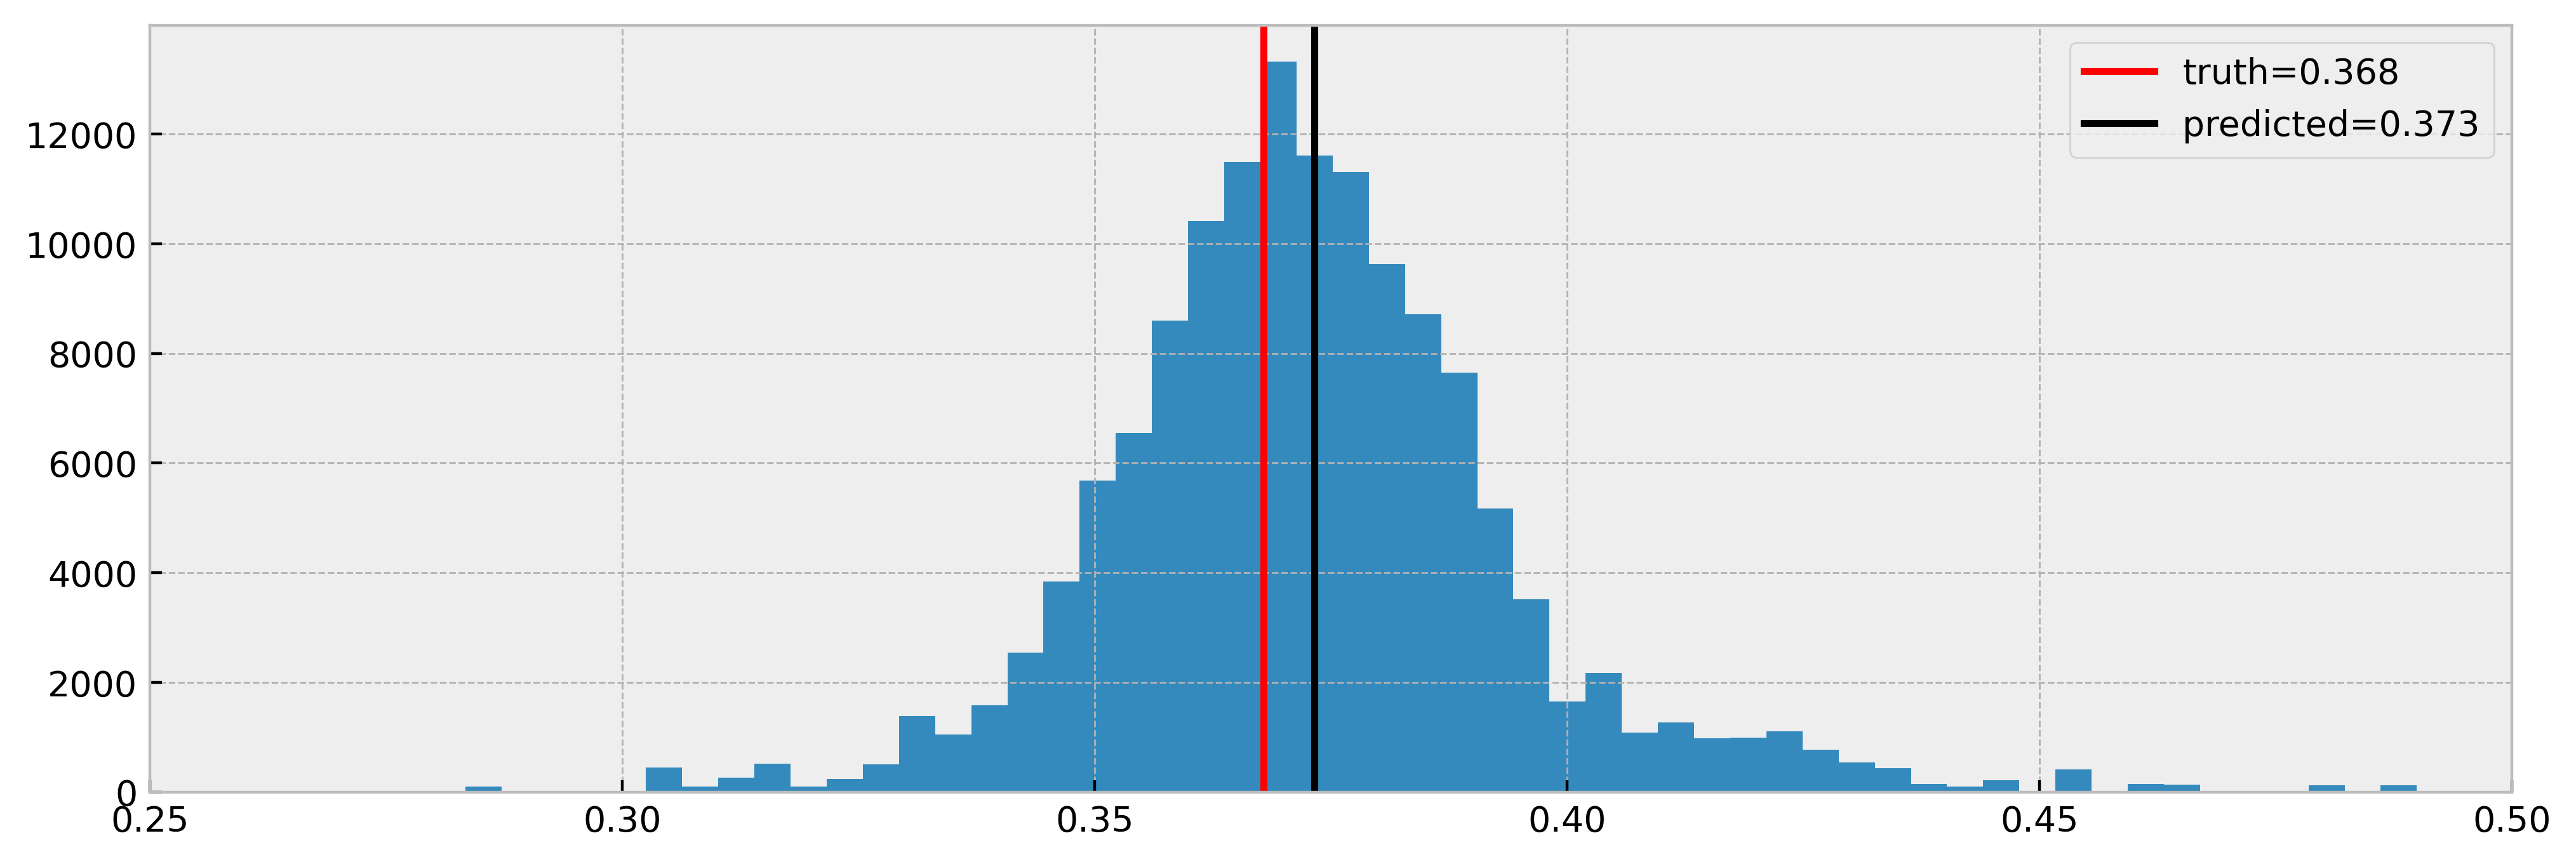

In [8]:
# importing matplotlib
import numpy as np
import matplotlib.pyplot as plt

# treatment effects
treatment_effects = counterfactuals['y_hat'][1]/counterfactuals['y_hat'][0]

# plotting effects
plt.style.use('bmh')
plt.figure(figsize=(12,4), dpi=200)
plt.hist(treatment_effects, bins=100);
plt.axvline(np.exp(-1), color='r', label='truth={}'.format(np.round(np.exp(-1), 3)))
plt.axvline(treatment_effects.mean(), color='k', label='predicted={}'.format(np.round(treatment_effects.mean(),3)))
plt.xlim(0.25, 0.50)
plt.legend()
plt.show()

The inference is good, but not perfect. We can observe that some estimates are way over the real values. Also, in a real causal inference setting the true effect would not be acessible as an observed quantity. That's why we perform CV only to diagnose the model's generalization power from `X`to `y`. For the treatment effect, we have to trust theory and have a set of diagnostic tools at our disposal. That's why we built `.run_leaf_diagnostics()` :). We'll show it in the next section.

## Digging deeper with *leaf diagnostics*

The `.run_leaf_diagnostics()` method provides valuable information to diagnose the countefactual predictions of the model. It performs analysis over the leaf nodes, testing if they really are the clusters containing the "identical enough" individuals we need.

We run the method and get the following dataframe:

In [9]:
# running leaf diagnostics
leaf_diagnostics_df = dtcf.run_leaf_diagnostics()
leaf_diagnostics_df.head()

avg_outcome           percentile_age           percentile_severity  \
W              0         1              0         1                   0   
leaf                                                                      
251    12.122137  5.600000       0.000618  0.000714            0.355810   
254    14.576000  5.676471       0.002818  0.002852            0.473568   
261    15.847826  5.250000       0.005908  0.006351            0.428452   
262    14.294521  5.909091       0.008595  0.008474            0.386490   
263    16.933333  6.965517       0.007064  0.007026            0.536432   

               percentile_sex           confounding_score  
W            1              0         1                    
leaf                                                       
251   0.524049       0.249052  0.249052          0.937786  
254   0.540473       0.249052  0.249052          0.807765  
261   0.451209       0.249052  0.249052          0.757246  
262   0.438147       0.249052  0.249052          0.793275  
263   0.541377       0.249052  0.249052          0.546552

The dataframe provides a diagnostic on leaves with enough samples for counterfactual inference, showing some interesting quantities:

* average outcomes across treatments (`avg_outcome`) 
* explanatory variable distribution across treatments (`percentile_*` variables) 
* a confounding score for each variable, meaning how much we can predict the treatment from explanatory variables inside leaf nodes using a linear model (`confounding_score`)

The most important column is the `confounding_score`, which tells us if treatments are not randomly assigned within leaves given explanatory variables. It is actually the AUC of a linear model that tries to tell treated from untreated individuals within each leaf. Let us check how our model fares on this score:

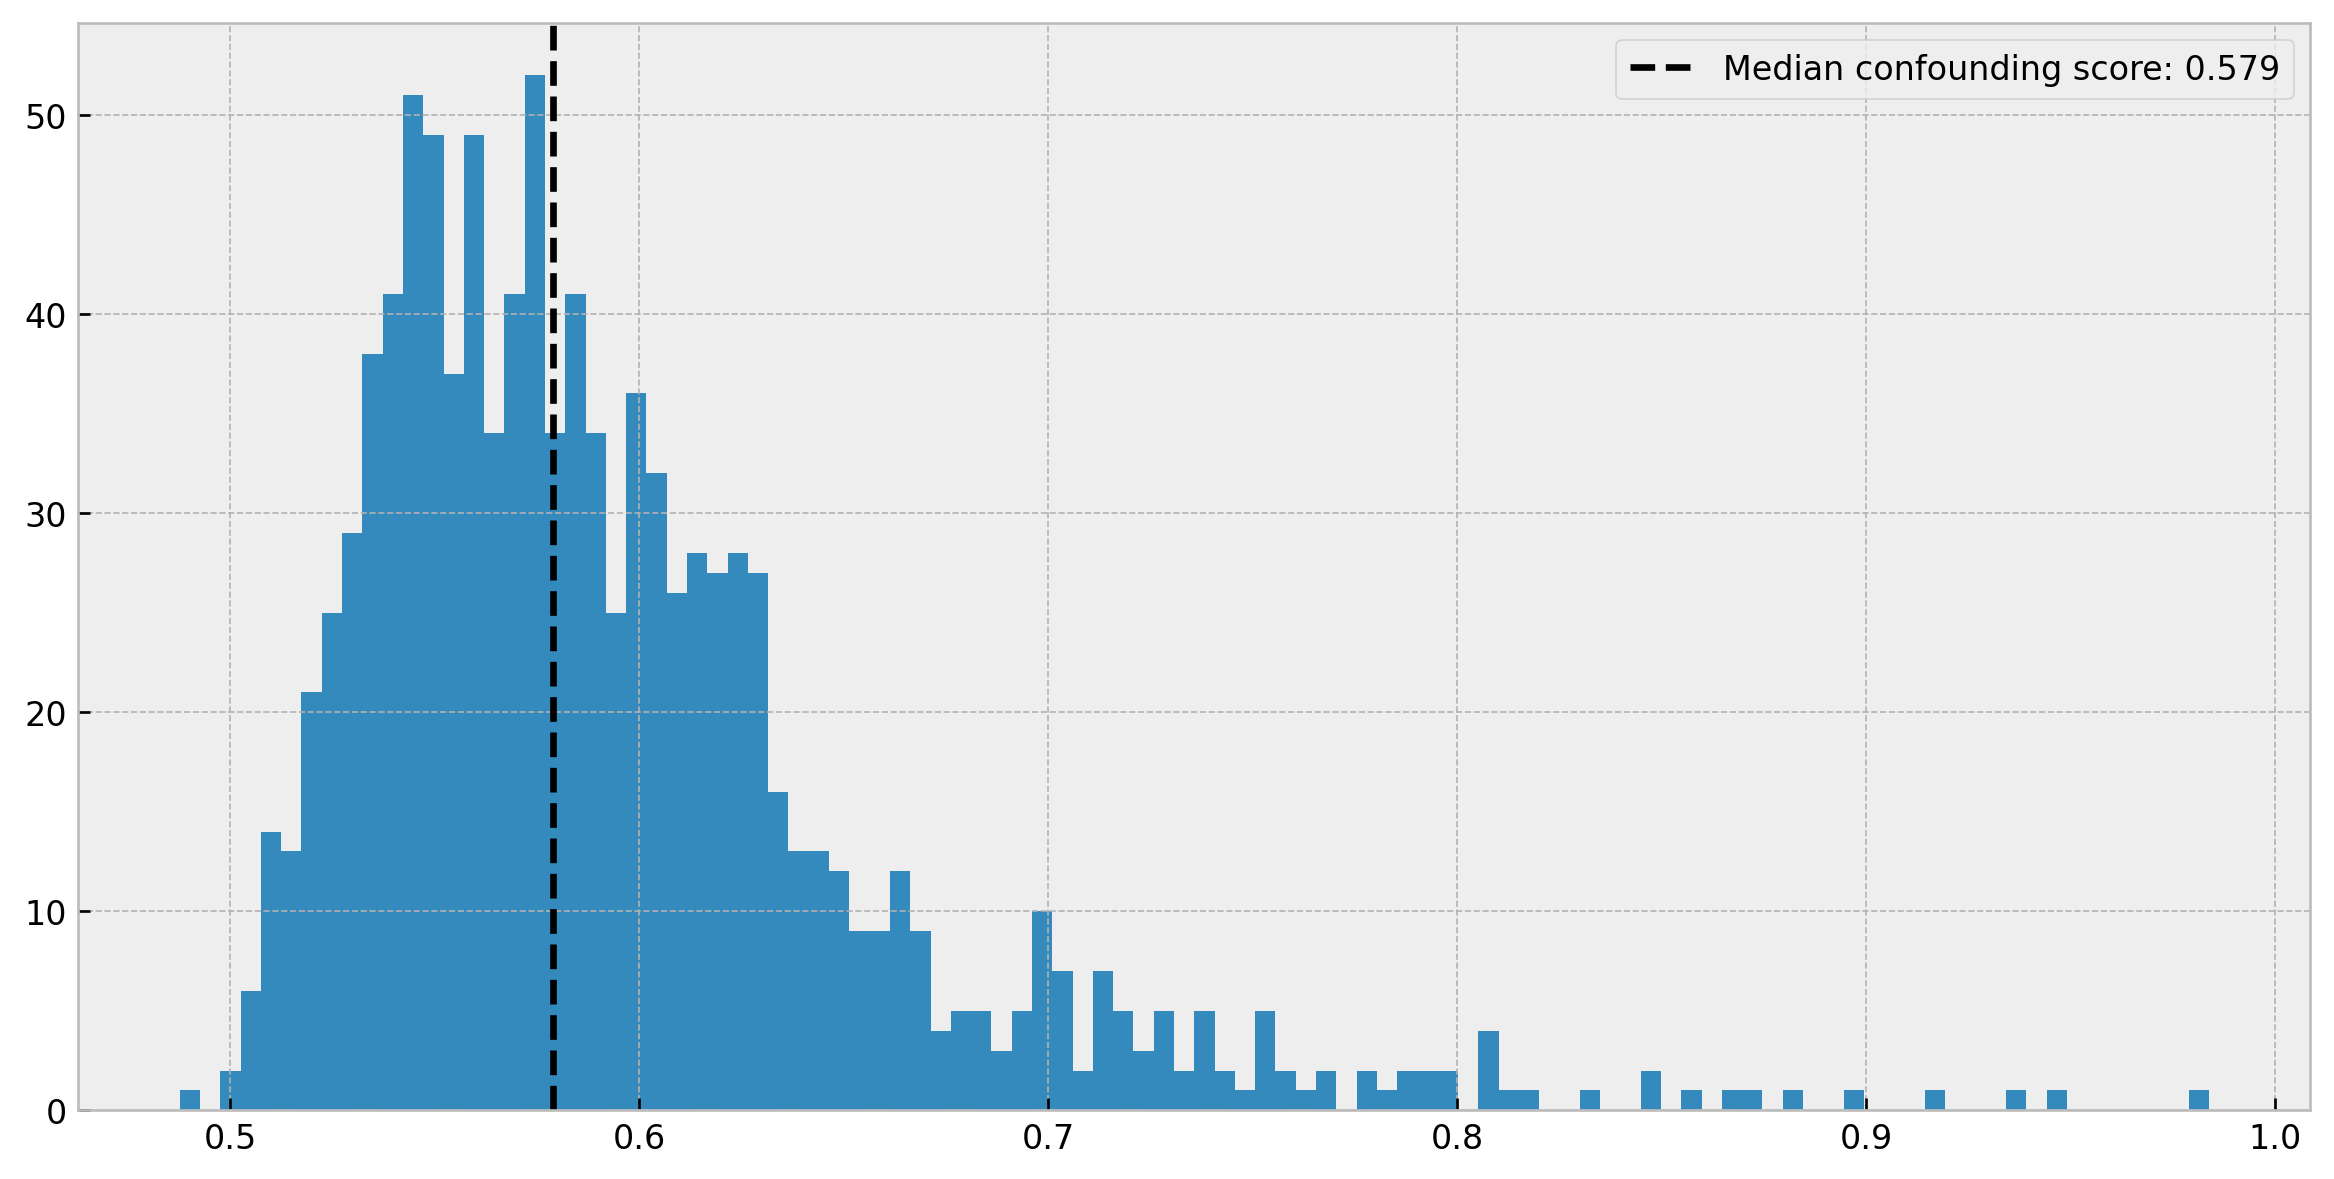

In [10]:
# avg confounding score
confounding_score_mean = leaf_diagnostics_df['confounding_score'].median()

# plotting
plt.figure(figsize=(12,6), dpi=120)
plt.axvline(
    confounding_score_mean,
    linestyle='dashed',
    color='black',
    label=f'Median confounding score: {confounding_score_mean:.3f}'
)
plt.hist(leaf_diagnostics_df['confounding_score'], bins=100);
plt.legend()

Cool. This is a good result, as within more than half of the leaves treated and untreated individuals are virtually indistinguishable (AUC less than 0.6). However, we can check that for some of the leaves we have a high confounding score. Therefore, in those cases, our individuals are be not "identical enough" and inference may be biased. 

We actually can measure how biased inference can be. Let us plot how the confounding score impacts the estimated effect.

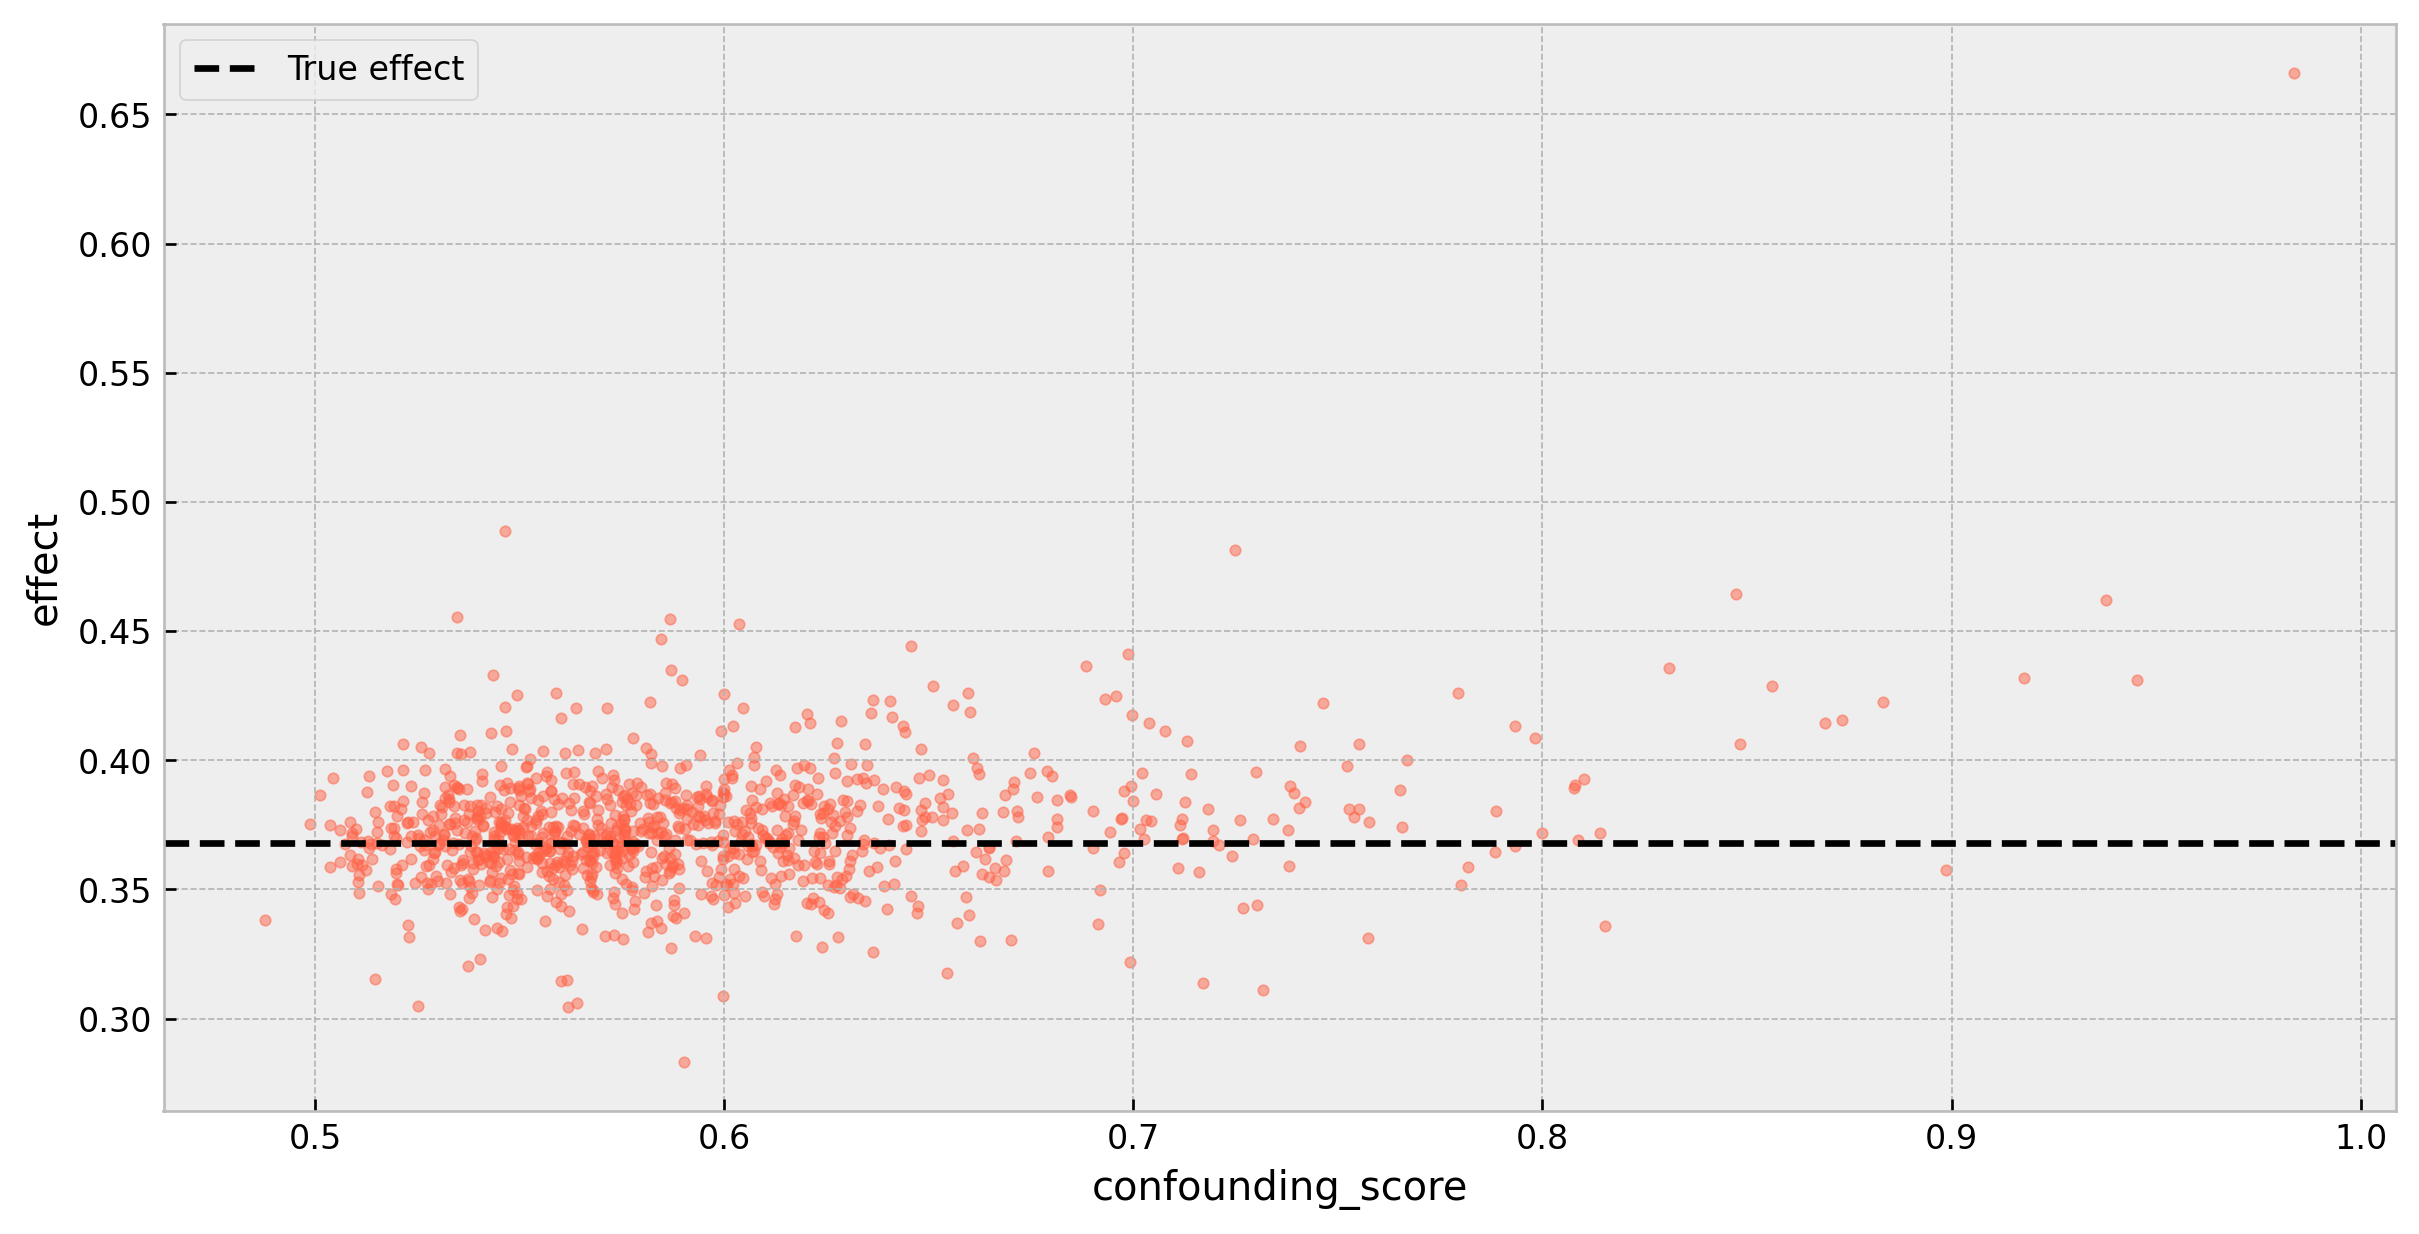

In [16]:
# adding effect to df
leaf_diagnostics_df = (
    leaf_diagnostics_df
    .assign(effect=lambda x: x['avg_outcome'][1]/x['avg_outcome'][0])
)

# real effect of fklearn's toy problem
real_effect = np.exp(-1)

# plotting
fig, ax = plt.subplots(1, 1, figsize=(12,6), dpi=120)

plt.axhline(
    real_effect,
    linestyle='dashed',
    color='black',
    label='True effect'
)

leaf_diagnostics_df.plot(
    x='confounding_score',
    y='effect',
    kind='scatter',
    color='tomato',
    s=10,
    alpha=0.5,
    ax=ax
)

plt.legend()

As we can see, there's a slight bias that presents itself with higher confounding scores:

In [12]:
effect_low_confounding = (
    leaf_diagnostics_df
    .loc[lambda x: x.confounding_score < 0.6]
    ['effect'].mean()
)

effect_high_confounding = (
    leaf_diagnostics_df
    .loc[lambda x: x.confounding_score > 0.8]
    ['effect'].mean()
)

print(f'Effect for leaves with confounding score < 0.6: {effect_low_confounding:.3f}')
print(f'Effect for leaves with confounding score > 0.8: {effect_high_confounding:.3f}')

Effect for leaves with confounding score < 0.6: 0.371
Effect for leaves with confounding score > 0.8: 0.421


Let's examine the leaf with highest confounding score:

In [13]:
# leaf with highest confounding score
leaf_diagnostics_df.sort_values('effect', ascending=False).head(1)

avg_outcome             percentile_age           percentile_severity  \
W              0           1              0         1                   0   
leaf                                                                        
7678  180.166667  119.976378       0.999834  0.999846            0.427037   

               percentile_sex           confounding_score    effect  
W            1              0         1                              
leaf                                                                 
7678  0.756851       0.365719  0.564013          0.983727  0.665919

It shows a confounding score of 0.983, so we can almost perfectly tell treated and untreated individuals apart using the explanatory variables. The effect is grossly underestimated, as $log(0.665) = -0.408$. Checking the feature percentiles, we can see a big difference in `severity` and `sex` for treated and untreated individuals. 

We can check these differences further by leveraging the stored training dataframe and building a boxplot:

<AxesSubplot:title={'center':'y'}, xlabel='W'>

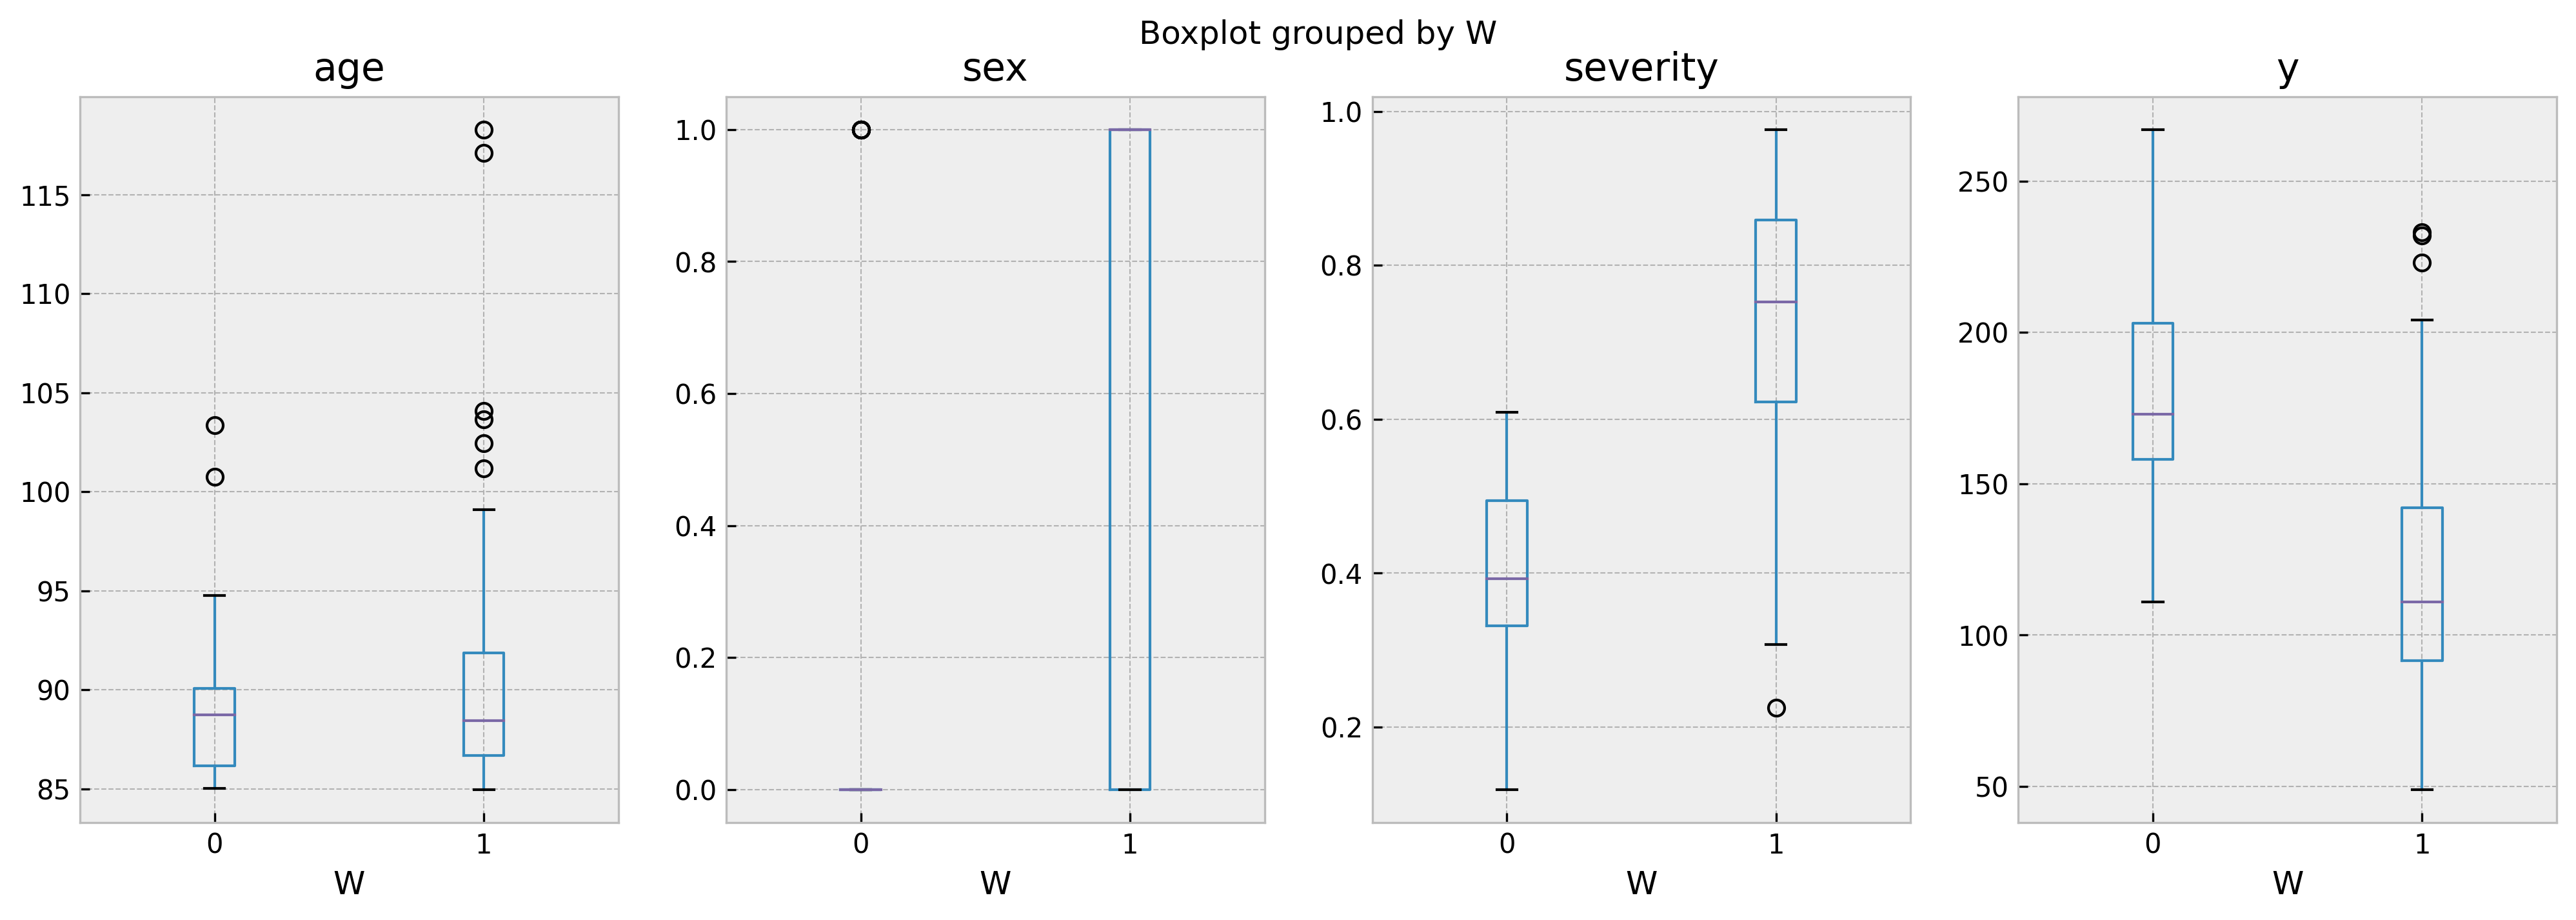

In [14]:
# getting the individuals from biased leaf
biased_leaf_samples = dtcf.train_df.loc[lambda x: x.leaf == 7678]

# plotting
fig, ax = plt.subplots(1, 4, figsize=(16, 5), dpi=150)
biased_leaf_samples.boxplot('age','W', ax=ax[0])
biased_leaf_samples.boxplot('sex','W', ax=ax[1])
biased_leaf_samples.boxplot('severity','W', ax=ax[2])
biased_leaf_samples.boxplot('y','W', ax=ax[3])

As we can see, ages are comparable but `sex` and `severity` are not. In a unbiased leaf, such as 263 (with confounding score of 0.54), the boxplots show much more homogenous populations:

<AxesSubplot:title={'center':'y'}, xlabel='W'>

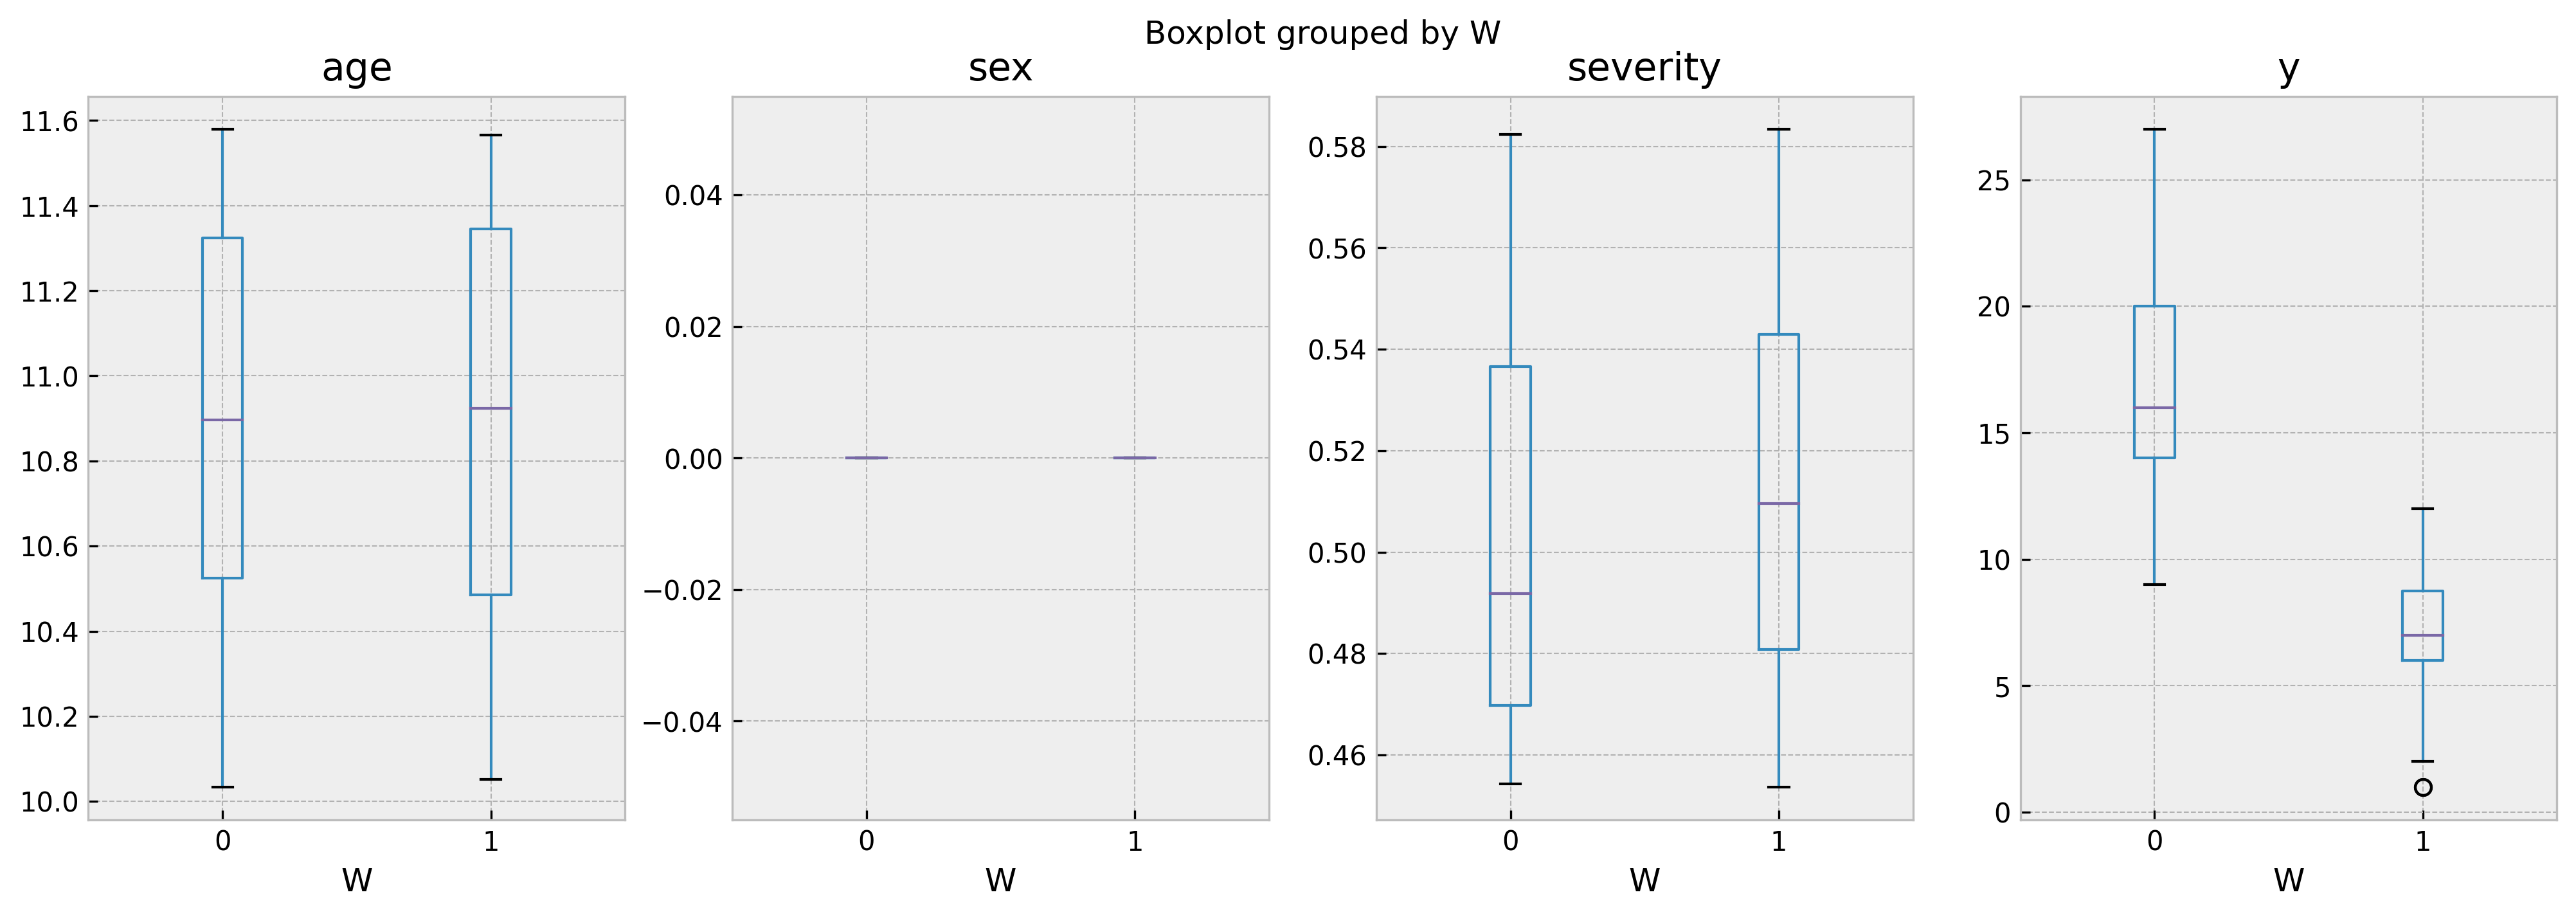

In [15]:
# getting the individuals from biased leaf
biased_leaf_samples = dtcf.train_df.loc[lambda x: x.leaf == 263]

# plotting
fig, ax = plt.subplots(1, 4, figsize=(16, 5), dpi=150)
biased_leaf_samples.boxplot('age','W', ax=ax[0])
biased_leaf_samples.boxplot('sex','W', ax=ax[1])
biased_leaf_samples.boxplot('severity','W', ax=ax[2])
biased_leaf_samples.boxplot('y','W', ax=ax[3])

And that's it! I hope this post help you in your journey to accurate, unbiased counterfactual predictions. All feedbacks are appreciated! 